In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
from numpy.random import seed
seed(1)


from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,  StandardScaler

from tensorflow.keras import layers
import tensorflow 
tensorflow.random.set_seed(1234)

from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor

import xgboost as xgb


import multiprocessing

import warnings
warnings.filterwarnings('once')


http://bibliotecadigital.agronet.gov.co/bitstream/11438/7825/1/OA-EVA-DSO-01_Dise%C3%B1o%20Metodologico_EVA_2014_Ajustes_obsMADR_v2Jul17.pdf


In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/CindyHernandezMelo/Proyecto_AML/main/Evaluaciones_Agropecuarias_Municipales_EVA_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/CindyHernandezMelo/Proyecto_AML/main/Evaluaciones_Agropecuarias_Municipales_EVA_test.csv')
test = test[test['anio']==2017]

In [3]:
def cambio_latitud_longitud(X):
  latitud_longitud = pd.read_csv('https://raw.githubusercontent.com/CindyHernandezMelo/Proyecto_AML/main/Longitud%20y%20Latitud.csv')

  X = pd.merge(X, latitud_longitud, on='cod_mun')

  X = X.dropna()
  X = X.reset_index(drop=True)
  return X


In [4]:
def cambio_altura_clima(X):
  altura_clima = pd.read_csv('https://raw.githubusercontent.com/CindyHernandezMelo/Proyecto_AML/main/Altura.csv')
  altura_clima =altura_clima.drop(['Departamento','Municipio'], 1)
  X = pd.merge(X, altura_clima, on='cod_mun')
  X['Altura'] = X['Altura'].str.replace(',', '').astype('int')
  X = X.reset_index(drop=True)
  return X


In [5]:
def borrar_ceros_outliers(X,  Q_r1, Q_r9, Q_p9, Q_a9):
  if Q_r1 == 0:
    X['rendimiento'] = X['prod'] / X['area_cosechada']
    Q_r9 = X['rendimiento'].quantile(0.99)
    Q_r1 = X['rendimiento'].quantile(0.01)
    Q_p9 = X['prod'].quantile(0.95)
    Q_a9 = X['area_cosechada'].quantile(0.95)

  index = (X['area_sembrada']>0) & (X['area_cosechada']>0)  & (X['prod']>0) & (X['rendimiento']>Q_r1) & (X['rendimiento']<Q_r9) & (X['area_cosechada']<Q_a9) & (X['prod']<Q_p9)

  X = X[index]
  X = X.reset_index(drop=True)
  return X, Q_r1, Q_r9, Q_p9, Q_a9

In [6]:
def  cambiar_areacosechada(X):
  X.loc[:,'area_cosechada_per'] = X['area_cosechada']*100 / X['area_sembrada']
  index = (X['area_cosechada_per']<=100) & (X['area_cosechada_per']>10)
  X['area_cosechada'] = np.log(X['area_cosechada'])
  X['prod'] = np.log(X['prod'])
  X['grupo_estado'] = 'Grupo: '+X['grp_cultivo']+'. Estado: '+X['estado_prod']
  X = X[index]
  X = X.reset_index(drop=True)
  return X

In [7]:
def ciclo_periodo(X):
  resp = ''
  if X['ciclo_cultivo'] == 'TRANSITORIO':
    if X['periodo'][-1]=='A':
      resp = 'Semestre A'
    else:
      resp = 'Semestre B'
  elif X['ciclo_cultivo'] == 'ANUAL':
    resp = 'Anual'
  else:
    resp = 'Permanente'

  return resp

def cambiar_ciclo_periodo(X):
  X['ciclo_periodo'] = X.apply(lambda row: ciclo_periodo(row), axis=1)
  return X

In [8]:
def eliminar_columnas(X):
  eliminar = ['cod_depto', 'desc_depto', 'cod_mun', 'desc_mun', 
              'periodo', 'area_cosechada_per', 'area_sembrada','rendimiento', 'sist_prod', 
              'nombre', 'ciclo_cultivo', 'grp_cultivo', 'estado_prod','cultivo', 'Altura', 'sbgrp_cultivo']

  X.drop(eliminar, inplace=True, axis=1)

In [9]:
class CustomOHE(BaseEstimator, TransformerMixin):

  def __init__(self):
      self.columnas = None

  def fit(self, X, y=None):
      onehot = OneHotEncoder()
      onehot.fit_transform(X)

      self.columnas =  onehot.get_feature_names()
      return self

  def transform(self, X):

      ohe = OneHotEncoder()

      encoded_test = ohe.fit_transform(X).toarray()
      columnas2 = ohe.get_feature_names()
      encoded_test = pd.DataFrame(encoded_test, columns = columnas2 )
      diferentes =  self.columnas[~ np.in1d(self.columnas,columnas2)]


      for i in diferentes:
        encoded_test[i] = 0

      return encoded_test[self.columnas]

In [10]:
train  = cambio_latitud_longitud(train)
train  = cambio_altura_clima(train)
train, Q_r1, Q_r9, Q_p9, Q_a9  = borrar_ceros_outliers(train,0,0,0,0)
train  = cambiar_areacosechada(train)
train = cambiar_ciclo_periodo(train)
eliminar_columnas(train)

y_train = train['prod']
X_train = train.drop(['prod'], axis=1)


In [11]:
X_train

,anio,area_cosechada,Longitud,Latitud,Clima,grupo_estado,ciclo_periodo
0,2010,0.000000,5.50000,-75.08333,Frío,Grupo: HORTALIZAS. Estado: FRUTO FRESCO,Semestre A
1,2010,0.000000,5.50000,-75.08333,Frío,Grupo: HORTALIZAS. Estado: FRUTO FRESCO,Semestre B
2,2010,3.912023,5.50000,-75.08333,Frío,Grupo: FRUTALES. Estado: FRUTO FRESCO,Permanente
3,2010,1.609438,5.50000,-75.08333,Frío,Grupo: LEGUMINOSAS. Estado: GRANO SECO,Semestre A
4,2010,1.609438,5.50000,-75.08333,Frío,Grupo: LEGUMINOSAS. Estado: GRANO SECO,Semestre B
...,...,...,...,...,...,...,...
105060,2016,4.615121,0.49389,-69.66694,Cálido húmedo,Grupo: TUBERCULOS Y PLATANOS. Estado: TUBERCUL...,Anual
105061,2013,3.178054,6.17194,-75.61139,Templado,Grupo: OTROS PERMANENTES. Estado: CAFE VERDE E...,Permanente
105062,2014,3.332205,6.17194,-75.61139,Templado,Grupo: OTROS PERMANENTES. Estado: CAFE VERDE E...,Permanente
105063,2015,3.258097,6.17194,-75.61139,Templado,Grupo: OTROS PERMANENTES. Estado: CAFE VERDE E...,Permanente


In [12]:
test  = cambio_latitud_longitud(test)
test  = cambio_altura_clima(test)
test, a, b, c, d = borrar_ceros_outliers(test, Q_r1, Q_r9, Q_p9, Q_a9)
test  = cambiar_areacosechada(test)
test = cambiar_ciclo_periodo(test)
test2 = test.copy()
eliminar_columnas(test)

y_test = test['prod']
X_test = test.drop(['prod'], axis=1)

In [13]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [14]:
from sklearn.impute import SimpleImputer
ct = ColumnTransformer([
       ('num', SimpleImputer(strategy = 'mean'),
       make_column_selector(dtype_include=np.number)),
        ('cat',
       CustomOHE(),
       make_column_selector(dtype_include=object))])

estimadores = [('encoder_imputer', ct)]

pipe = Pipeline(estimadores)

X_trainOHE = pd.DataFrame(pipe.fit_transform(X_train), columns=pd.get_dummies(X_train).columns)
X_testOHE = pd.DataFrame(pipe.transform(X_test), columns=pd.get_dummies(X_train).columns)


In [15]:
model = RandomForestRegressor(random_state=1234)
param_search = { 
    'n_estimators': [20, 50, 100, 150, 200],
    'max_depth':[10,20,30,50],
}
tscv = TimeSeriesSplit(n_splits=2, max_train_size= np.shape(X_train[X_train['anio']==2016]) [0])

gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_root_mean_squared_error',   return_train_score=True)
gsearch.fit(X_trainOHE, y_train)


gsearch.best_estimator_


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)

In [16]:
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

y_true = y_test.values
y_pred = best_model.predict(X_testOHE)

regression_results(y_true, y_pred)
regression_results(np.exp(y_true), np.exp(y_pred))
  

explained_variance:  0.9097
r2:  0.9095
MAE:  0.3965
MSE:  0.3188
RMSE:  0.5646
explained_variance:  0.8518
r2:  0.848
MAE:  141.042
MSE:  121278.5181
RMSE:  348.2507


<Figure size 576x576 with 0 Axes>

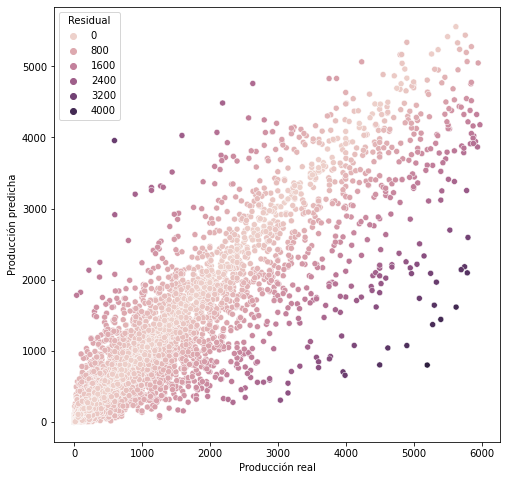

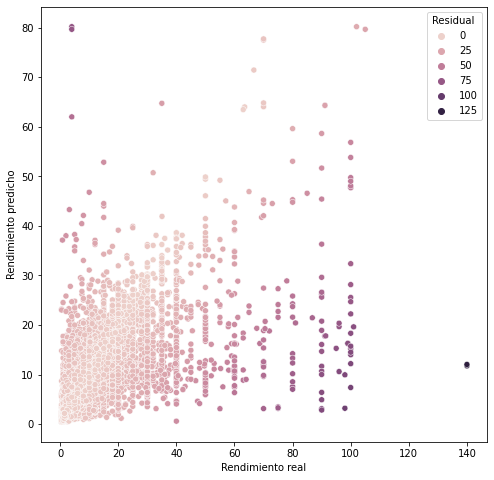

In [17]:
plt.figure(figsize=(8,8))
resultados = pd.DataFrame({'Producción real':np.exp(y_true), 
                           'Producción predicha':np.exp(y_pred), 
                           'Residual':np.abs(np.exp(y_true)-np.exp(y_pred)), 
                           'Rendimiento real': np.exp(y_true)/np.exp(X_test['area_cosechada']),
                           'Rendimiento predicho': np.exp(y_pred)/np.exp(X_test['area_cosechada'])})
resultados['Residual '] = np.abs(resultados['Rendimiento predicho']- resultados['Rendimiento real'])
plt.figure(figsize=(8,8))
sns.scatterplot(data=resultados, x='Producción real', y='Producción predicha', hue="Residual")
plt.figure(figsize=(8,8))
sns.scatterplot(data=resultados, x='Rendimiento real', y='Rendimiento predicho', hue="Residual ", color='b')


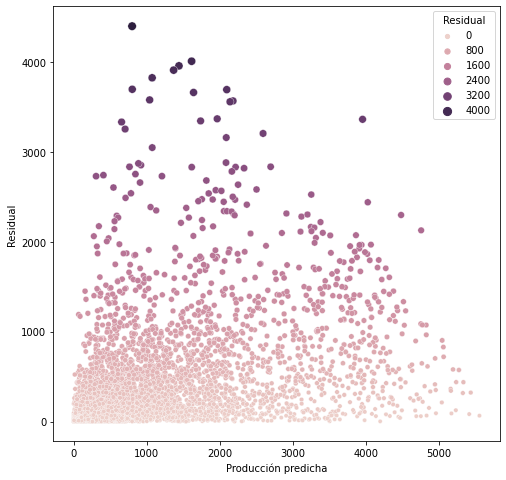

In [18]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=resultados, x='Producción predicha', y='Residual', hue="Residual",  size="Residual")

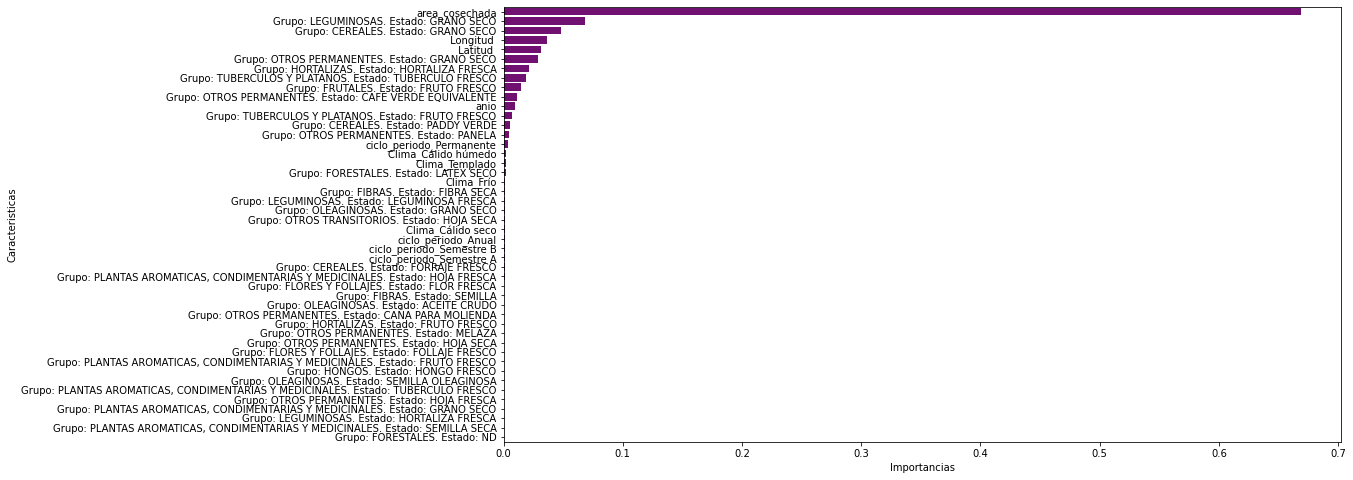

In [19]:
importances = pd.DataFrame({'Importancias':best_model.feature_importances_, 'Caracteristicas':pd.get_dummies(X_train).columns.str.replace('grupo_estado_','')})
importances = importances.sort_values("Importancias", ascending=False)
plt.figure(figsize=(15,8))
sns.set_color_codes("muted")

sns.barplot(x="Importancias", y="Caracteristicas", data=importances, 
            color="purple")

In [20]:

xgb_reg=xgb.XGBRegressor()

prams={
    'learning_rate':[0.05,0.1, 0.25],
    'n_estimators':[50, 100, 150, 200],
    'max_depth':[10,20,30, 50],
}

random_clf=GridSearchCV(xgb_reg, param_grid=prams,verbose=1, return_train_score=True,
                                n_jobs=-1, cv = tscv)
random_clf.fit(X_trainOHE, y_train)

random_clf.best_estimator_



Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 11.0min finished


[01:06:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [21]:
best_score = random_clf.best_score_
best_model = random_clf.best_estimator_

y_true = y_test.values
y_pred = best_model.predict(X_testOHE)


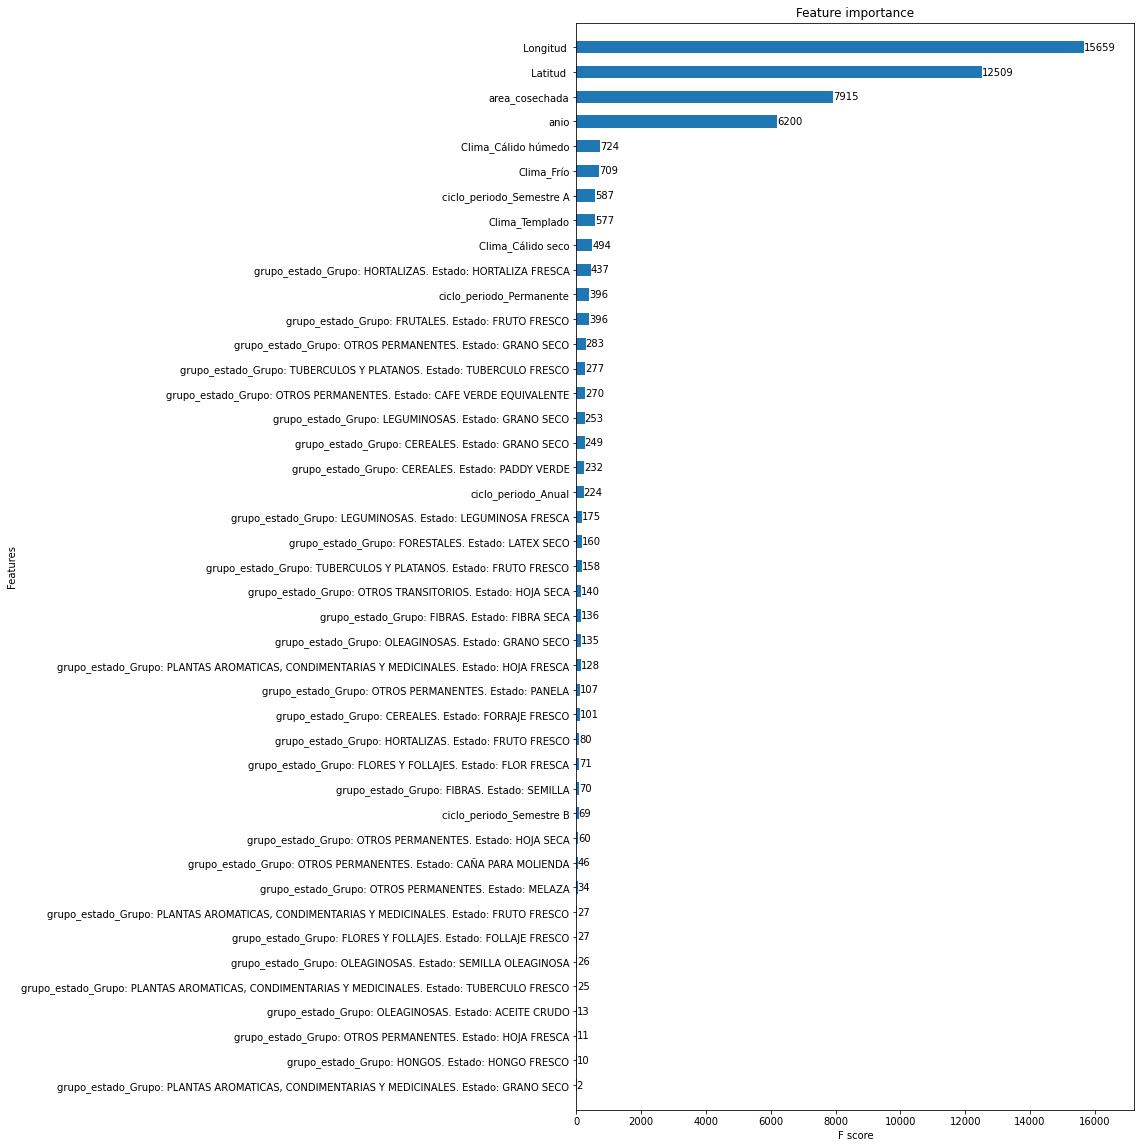

In [22]:
fig, ax = plt.subplots(figsize=(10,20))
xgb.plot_importance(best_model, height=0.5, ax=ax, grid= False)
plt.show()

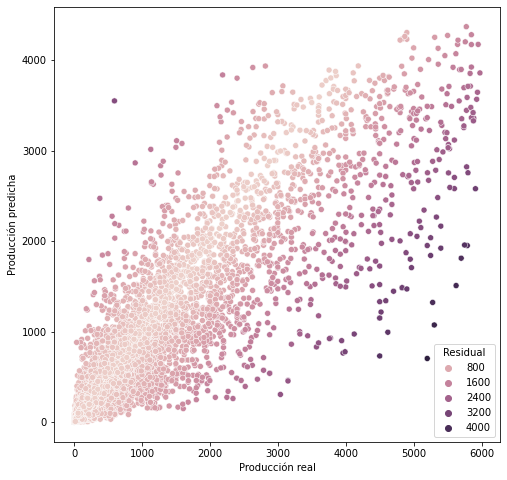

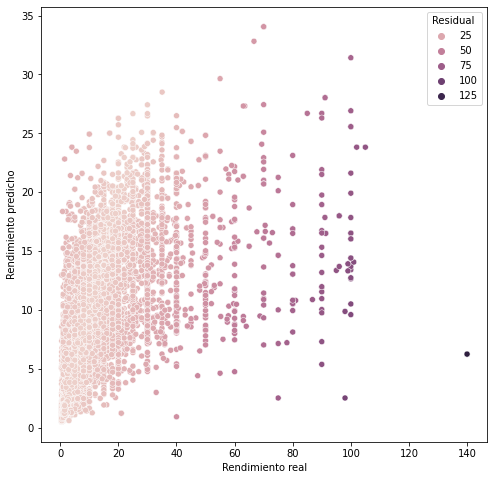

In [23]:
plt.figure(figsize=(8,8))
resultados = pd.DataFrame({'Producción real':np.exp(y_true), 
                           'Producción predicha':np.exp(y_pred), 
                           'Residual':np.abs(np.exp(y_true)-np.exp(y_pred)), 
                           'Rendimiento real': np.exp(y_true)/np.exp(X_test['area_cosechada']),
                           'Rendimiento predicho': np.exp(y_pred)/np.exp(X_test['area_cosechada'])})
resultados['Residual '] = np.abs(resultados['Rendimiento predicho']- resultados['Rendimiento real'])
sns.scatterplot(data=resultados, x='Producción real', y='Producción predicha', hue="Residual")
plt.figure(figsize=(8,8))
sns.scatterplot(data=resultados, x='Rendimiento real', y='Rendimiento predicho', hue="Residual ")


In [24]:
regression_results(y_true, y_pred)
regression_results(np.exp(y_true), np.exp(y_pred))

explained_variance:  0.9039
r2:  0.9032
MAE:  0.4297
MSE:  0.3411
RMSE:  0.5841
explained_variance:  0.8039
r2:  0.794
MAE:  163.5919
MSE:  164278.2755
RMSE:  405.3126


In [25]:
from sklearn.neighbors import KNeighborsRegressor
KNN_algorithm = KNeighborsRegressor()
prams={'n_neighbors': [4,8,16], 
       'weights': ['uniform','distance'],
       'p':[1,2]}


ksearch = GridSearchCV(estimator=KNN_algorithm, cv=tscv, param_grid=prams, scoring = 'neg_root_mean_squared_error',   return_train_score=True)
ksearch.fit(X_trainOHE, y_train)

ksearch.best_estimator_


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=1,
                    weights='distance')

In [26]:
best_score = ksearch.best_score_
best_model = ksearch.best_estimator_

y_true = y_test.values
y_pred = best_model.predict(X_testOHE)

In [27]:
regression_results(y_true, y_pred)
regression_results(np.exp(y_true), np.exp(y_pred))

explained_variance:  0.8936
r2:  0.8935
MAE:  0.4524
MSE:  0.3752
RMSE:  0.6125
explained_variance:  0.7841
r2:  0.7735
MAE:  170.3474
MSE:  180667.4527
RMSE:  425.0499


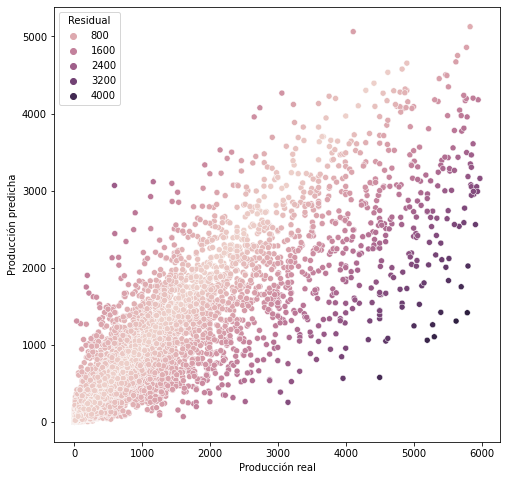

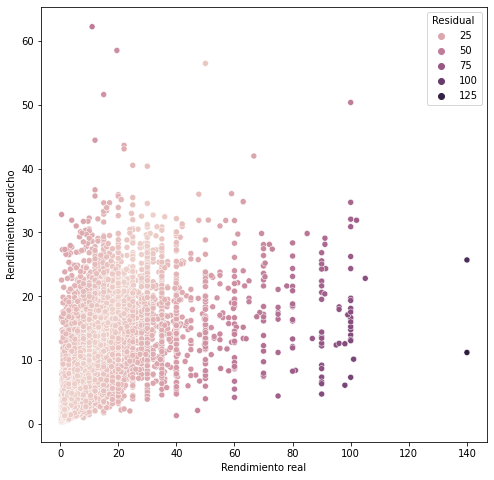

In [28]:
plt.figure(figsize=(8,8))
resultados = pd.DataFrame({'Producción real':np.exp(y_true), 
                           'Producción predicha':np.exp(y_pred), 
                           'Residual':np.abs(np.exp(y_true)-np.exp(y_pred)), 
                           'Rendimiento real': np.exp(y_true)/np.exp(X_test['area_cosechada']),
                           'Rendimiento predicho': np.exp(y_pred)/np.exp(X_test['area_cosechada'])})
resultados['Residual '] = np.abs(resultados['Rendimiento predicho']- resultados['Rendimiento real'])
sns.scatterplot(data=resultados, x='Producción real', y='Producción predicha', hue="Residual")
plt.figure(figsize=(8,8))
sns.scatterplot(data=resultados, x='Rendimiento real', y='Rendimiento predicho', hue="Residual ")


In [29]:
import keras 
def build_model():
  model = Sequential([

    layers.Dense(64, activation='relu', input_shape=[46]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mae', 'mse'])
  return model

model = build_model()
# Gradient descent algorithm

estimator = KerasRegressor(build_fn=build_model, epochs=100, batch_size=5, verbose=0)

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('\n')
    print('*', end='')

EPOCHS = 50

history = model.fit(
  X_trainOHE[X_train['anio']!=2016], y_train[X_train['anio']!=2016],
  epochs=EPOCHS, validation_data = (X_trainOHE[X_train['anio']==2016],y_train[X_train['anio']==2016]),verbose=0,
  callbacks=[PrintDot()])



**********

**********

**********

**********

**********

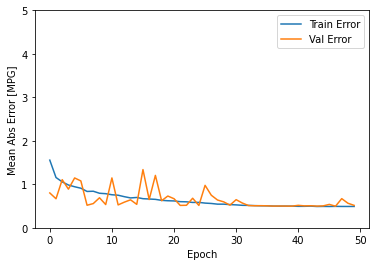

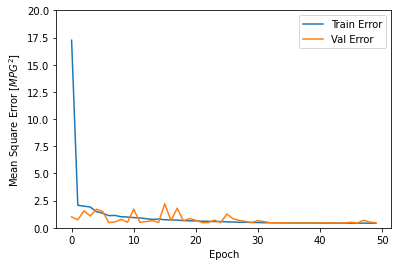

In [30]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)
